In [ ]:
#https://www.kaggle.com/apapiu/regularized-linear-models
#Data Location: C:\Users\sjain191\Desktop\ML_Learning\Data_For_ML\Linear_Regression_Model_Data-1

# For XGBoost Example: 
# 1. https://www.kaggle.com/zoupet/xgboost-ridge-lasso
# 2. https://www.kaggle.com/tadepalli/xgboost-with-n-trees-autostop-0-12638

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv('C:/Users/sjain191/Desktop/ML_Learning/Data_For_ML/Linear_Regression_Model_Data-1/train.csv')
test = pd.read_csv('C:/Users/sjain191/Desktop/ML_Learning/Data_For_ML/Linear_Regression_Model_Data-1/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BE2A263308>,
      dtype=object)

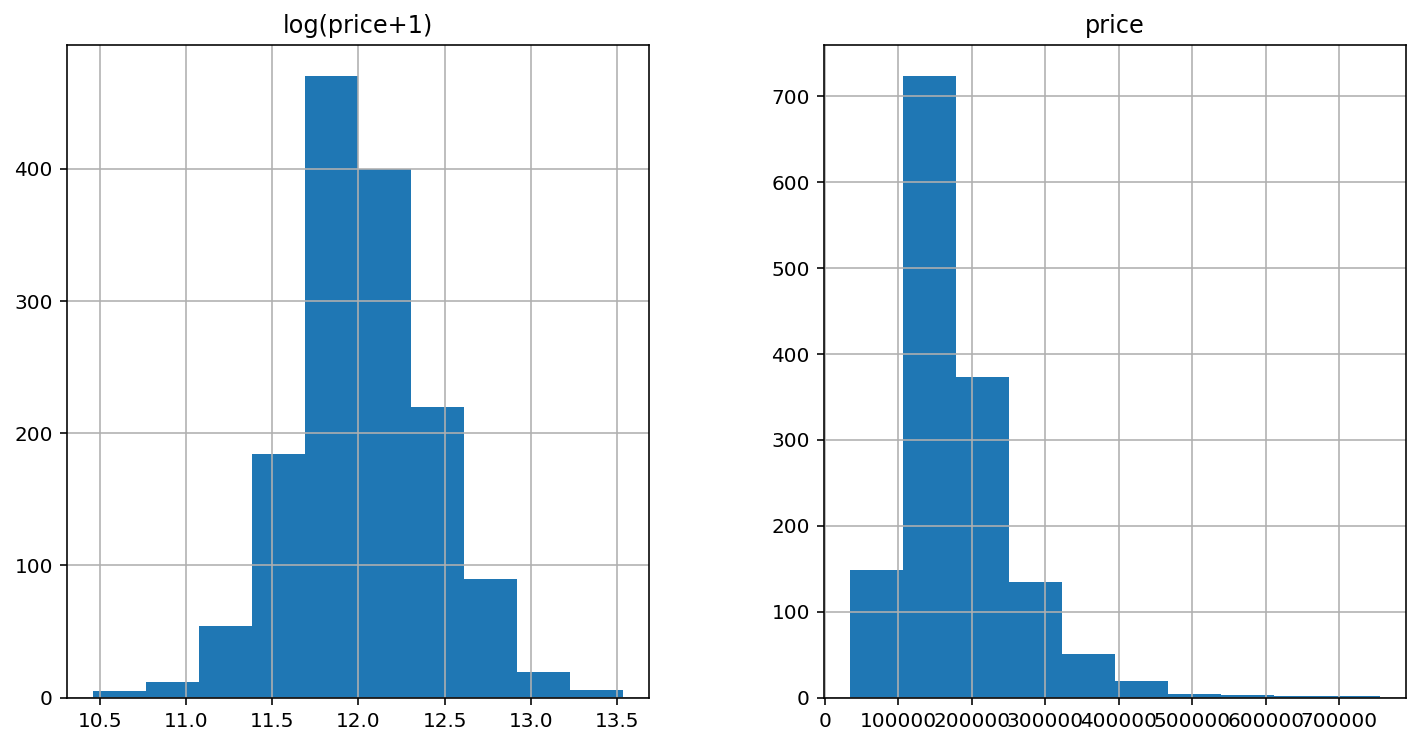

In [7]:
#Data preprocessing:-->
#First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
#Create Dummy variables for the categorical features
#Replace the numeric missing values (NaN's) with the mean of their respective columns

matplotlib.rcParams['figure.figsize'] = (12.0,6.0)
prices = pd.DataFrame({"price":train["SalePrice"],"log(price+1)":np.log1p(train["SalePrice"])})
prices.hist()

In [9]:
# Log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
#all_data.dtypes  #to check all data type
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)


In [15]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [16]:
x_train = all_data[:train.shape[0]]
x_test = all_data[train.shape[0]:]
y = train.SalePrice

In [17]:
# Preparing for model:
# I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. 
# I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, x_train, y, scoring='neg_mean_squared_error',cv=5))
    return(rmse)

model_ridge = Ridge()

In [20]:
# The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. 
#The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

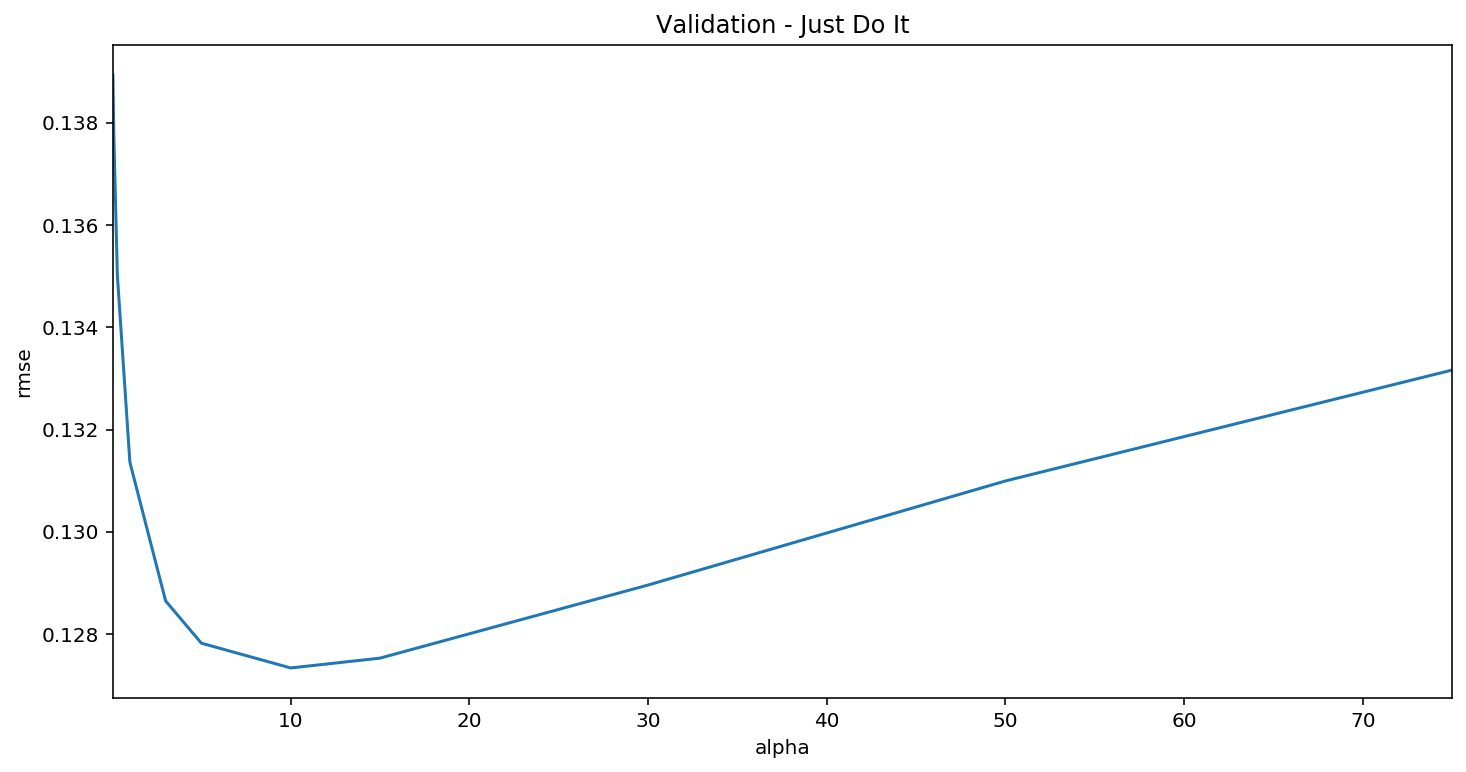

In [21]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [22]:
cv_ridge.min()

0.12733734668670774

In [23]:
#Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. 
#For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x_train, y)

C:\Users\sjain191\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
rmse_cv(model_lasso).mean()

C:\Users\sjain191\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sjain191\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sjain191\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sjain191\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change

0.1231442109097743

In [25]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)

In [26]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [27]:
#We can also take a look directly at what the most important coefficients are:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

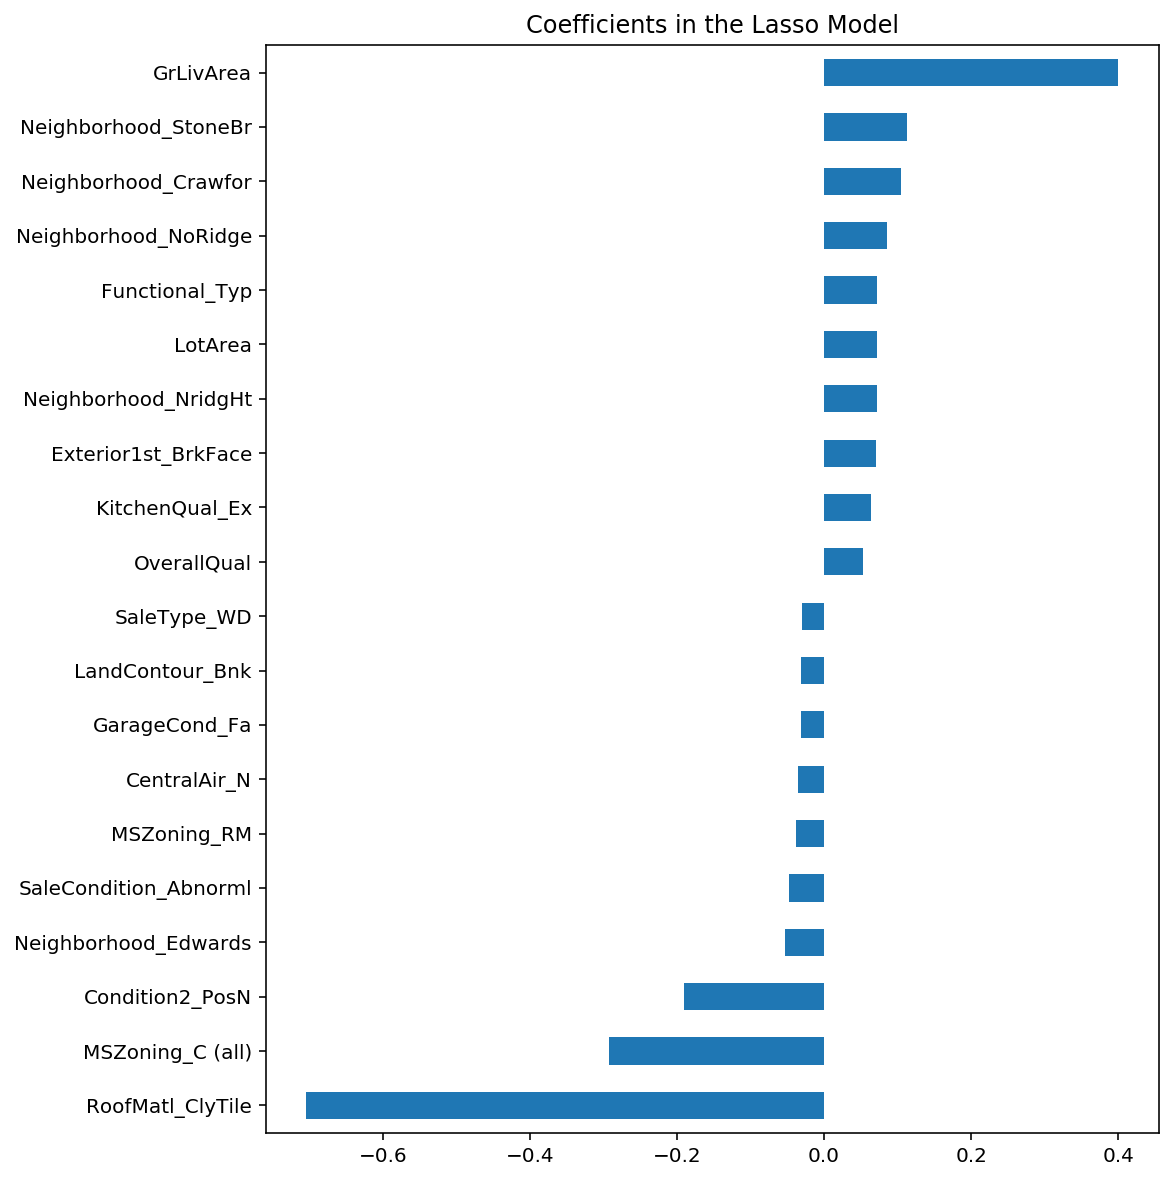

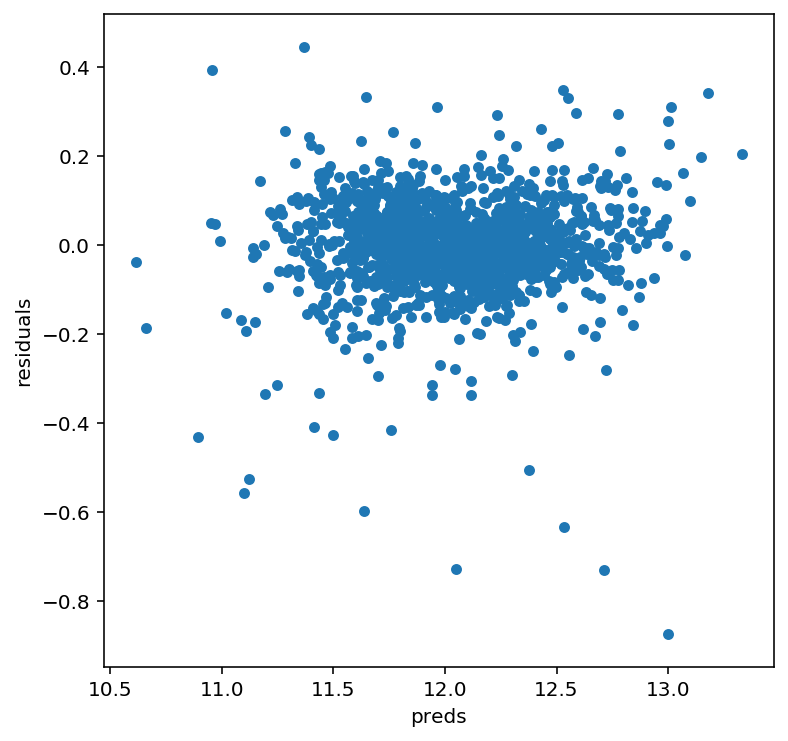

In [29]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(x_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")